# Settings

In [5]:
import numpy as np
import pandas as pd

pd.set_option('max.colwidth', 500)

In [6]:
%reload_ext rpy2.ipython

# Scraping scripts

## Titles only

## Full article info

# Import data

In [7]:
titles = pd.read_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/raw/medium_titles_2016.csv")

full = pd.read_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/raw/medium_full_2016.csv")

In [8]:
print("Full:", full.shape)
print("Titles:", titles.shape)

Full: (4783, 9)
Titles: (4982, 2)


# Clean URL in full article data table

In [9]:
full['articleLink'] = full['articleURL'].str.split('?').str[0]

full.drop('articleURL', axis=1, inplace=True)

full.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(full.shape)

(4725, 9)


# Clean URL in titles data table

In [10]:
titles['articleLink'] = titles['articleURL'].str.split('?').str[0]

titles.drop('articleURL', axis=1, inplace=True)

titles.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(titles.shape)

(4775, 2)


# Merge two data tables to get full set of links

In [11]:
merged = full.merge(titles, how='outer', left_on='articleLink', right_on='articleLink' )

merged.drop(['article_x', 'article_y'], axis=1, inplace=True)

# Analyze titles

## Parse URL slugs for title

In [12]:
## Remove NULLs in articleLink column 
merged.dropna(subset=['articleLink'], inplace=True)

In [13]:
for index, row in merged.iterrows():
    for link in row['articleLink'].split('/'):
        if '-' in link:
            words = link.split('-')[:-1]
            merged.loc[index, 'names'] = ' '.join(words)

## Title bigram relationships

### Get title bigrams counts 

In [14]:
## Remove NULLs in parsed article title column 
merged.dropna(subset=['names'], inplace=True)

In [15]:
import collections
import nltk

import spacy
from spacy_langdetect import LanguageDetector

nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

counts = collections.Counter()

for sent in merged["names"]:
    doc = nlp(sent)
    test1 = []
    if doc._.language['language'] == 'en':
        for token in doc:
            if token.is_alpha:
                test1.append(token.text.lower())
    counts.update(nltk.bigrams(test1))

In [16]:
bigram_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()

bigram_counts.columns = ["Bigrams", 'Count']

bigram_counts[['Term1', 'Term2']] = pd.DataFrame(bigram_counts['Bigrams'].tolist(), index=bigram_counts.index)  

In [17]:
bigram_counts = bigram_counts[['Term1', 'Term2', 'Count']]

bigram_counts.columns = ['word1', 'word2', 'n']

bigram_counts.sort_values(by='n', ascending=False)

,word1,word2,n
152,data,science,352
264,machine,learning,198
76,big,data,167
234,how,to,127
72,in,the,86
248,a,data,84
112,of,data,79
188,the,data,76
563,data,scientist,73
1178,of,the,65


In [18]:
bigram_counts.to_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2016_title_bigram_counts.csv", 
                     index=False)

### Visualize bigram relationships

In [1]:
%reload_ext rpy2.ipython

In [6]:
%%R 

library(igraph)

bigram_counts <- read.csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2016_title_bigram_counts.csv")

#bigram_counts <- head(bigram_counts[order(-bigram_counts$n),], 0.005*nrow(bigram_counts))

bigram_counts <- head(bigram_counts[order(-bigram_counts$n),], 60)

bigram_graph <- bigram_counts %>%
  graph_from_data_frame()

bigram_graph

IGRAPH a260552 DN-- 64 86 -- 
+ attr: name (v/c), n (e/n)
+ edges from a260552 (vertex names):
 [1] data        ->science    machine     ->learning   big         ->data      
 [4] how         ->to         in          ->the        a           ->data      
 [7] of          ->data       the         ->data       data        ->scientist 
[10] of          ->the        data        ->analysis   and         ->the       
[13] data        ->scientists data        ->analytics  for         ->data      
[16] what        ->is         your        ->data       the         ->future    
[19] in          ->r          in          ->data       to          ->do        
[22] data        ->driven     on          ->the        introduction->to        
+ ... omitted several edges


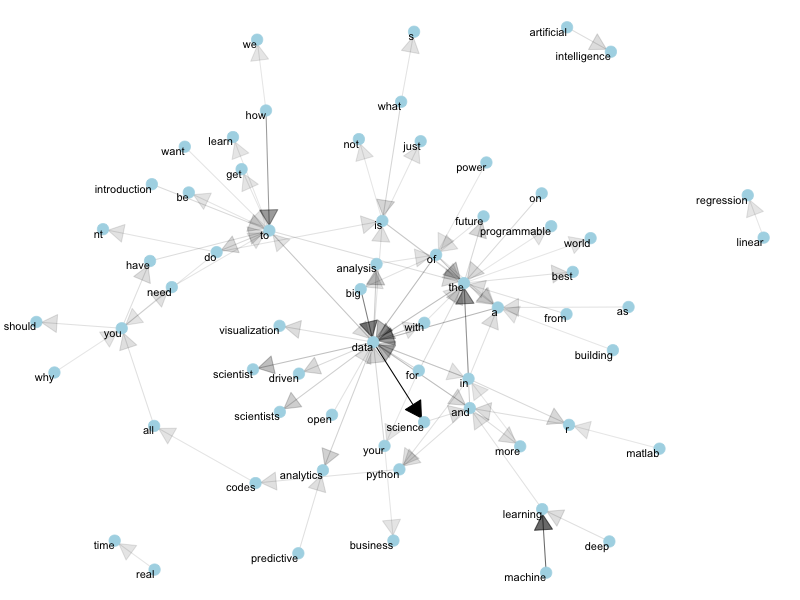

In [7]:
%%R -w 800 -h 600

library(ggraph)

set.seed(2016)

a <- grid::arrow(type = "closed")

options(repr.plot.width=12, repr.plot.height=8)
        
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

# Association rule analysis of tags

In [13]:
urls_missing_tags = merged[merged['articleTags'].isnull()]

urls_missing_tags

,NumOfClaps,NumOfComments,articleTags,linkOfAuthorProfile,nameOfAuthor,postingTime,readingTime,articleLink
337,NaN,NaN,NaN,,NaN,"February 14, 2016",,https://dickeysingh.com/2016/02/14/growth-hacking-is-part-art-and-part-science-68e48329915/
1633,NaN,NaN,NaN,,NaN,NaN,,https://medium.com/@upal/how-to-use-machine-learning-to-debug-outages-10x-faster-e480b7e2a907
2366,NaN,NaN,NaN,,NaN,"August 25, 2016",,https://blog.locus.sh/we-see-dimensions-that-you-wont-3a5f760dd198/
2666,NaN,NaN,NaN,,NaN,NaN,,https://data.world/blog/
3781,NaN,NaN,NaN,,NaN,"November 2, 2017",,https://blog.locus.sh/followed-by-randomness-245d4f7d6f64/
4725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://blog.ahmedkamal.me/why-should-you-care-about-big-data-data-science-cbf3ea5c7aef
4727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://genomix.me/molecular-predictors-of-alzheimer-s-disease-a-collaboration-with-sage-bionetworks-my-insight-1c130524d39
4728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://blog.transcendingdigital.space/the-future-will-be-built-on-open-data-heres-why-f76495507da9
4729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://dickeysingh.com/growth-hacking-is-part-art-and-part-science-68e48329915
4730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://blog.tracchicago.com/how-much-data-is-too-much-a1bbed7f7688


## Try to scrape links missing tags --> failed

## Prepare tags data

In [14]:
tags = merged['articleTags'].str.split(',', expand=True)

tags = tags.fillna('')

In [15]:
tags.replace('Data Science', '', inplace=True)
tags.replace('Datascience', '', inplace=True)

In [16]:
tags.to_csv('2016_tags.csv', index=False)

## Itemset mining

In [18]:
%%R 

library(arules)

tr <- read.transactions("2016_tags.csv", format = 'basket', sep=',')

R[write to console]: Error in file(con, "r") : cannot open the connection
Calls: <Anonymous> ... withVisible -> read.transactions -> lapply -> readLines -> file

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In file(con, "r") :
R[write to console]: 
 
R[write to console]:  cannot open file '2016_tags.csv': No such file or directory




Error in file(con, "r") : cannot open the connection
Calls: <Anonymous> ... withVisible -> read.transactions -> lapply -> readLines -> file


In [19]:
%%R

summary(tr)

transactions as itemMatrix in sparse format with
 4780 rows (elements/itemsets/transactions) and
 2363 columns (items) and a density of 0.001144386 

most frequent items:
               Big Data        Machine Learning      Data Visualization 
                   1460                    1073                     476 
              Analytics Artificial Intelligence                 (Other) 
                    421                     337                    9159 

element (itemset/transaction) length distribution:
sizes
   0    1    2    3    4    5 
 102  712 1503  645 1817    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   3.000   2.704   4.000   5.000 

includes extended item information - examples:
  labels
1      0
2      1
3      2


In [20]:
%%R

itms <- itemFrequency(tr, type = "relative")
data.frame(sort(itms, decreasing = TRUE))

                          sort.itms..decreasing...TRUE.
Big Data                                   0.3054393305
Machine Learning                           0.2244769874
Data Visualization                         0.0995815900
Analytics                                  0.0880753138
Artificial Intelligence                    0.0705020921
Data                                       0.0483263598
Python                                     0.0445606695
Startup                                    0.0435146444
Statistics                                 0.0357740586
Tech                                       0.0297071130
Programming                                0.0288702929
Technology                                 0.0240585774
Data Analysis                              0.0232217573
Open Data                                  0.0207112971
Marketing                                  0.0198744770
Deep Learning                              0.0192468619
Politics                                   0.018

In [21]:
%%R

itemsets <- apriori(tr, parameter = list(supp=0.001, conf=0.8, target='frequent', minlen=3))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
         NA    0.1    1 none FALSE            TRUE       5   0.001      3
 maxlen            target   ext
     10 frequent itemsets FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[2363 item(s), 4780 transaction(s)] done [0.01s].
sorting and recoding items ... [365 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [69 set(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [22]:
%%R

quality(itemsets)$lift <- interestMeasure(itemsets, measure='lift', tr)

inspect(sort(itemsets, by ='count', decreasing = T))

     items                         support count         lift
[1]  {Artificial Intelligence,                               
      Big Data,                                              
      Machine Learning}        0.015899582    76    3.2891744
[2]  {Artificial Intelligence,                               
      Deep Learning,                                         
      Machine Learning}        0.007740586    37   25.4120714
[3]  {Big Data,                                              
      Deep Learning,                                         
      Machine Learning}        0.005020921    24    3.8047544
[4]  {Analytics,                                             
      Big Data,                                              
      Data}                    0.004184100    20    3.2183914
[5]  {Artificial Intelligence,                               
      Big Data,                                              
      Deep Learning}           0.003765690    18    9.0856858
[6]  {Bi